<a href="https://colab.research.google.com/github/FourLevel/Machine-Learning-and-Financial-Applications/blob/main/Homework%203_Random%20Forest%20on%200050%20ETF/Homework%203_Random%20Forest%20on%200050%20ETF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 0050 Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2)
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from yfinance

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
!pip install tensorflow
#!pip install tensorflow-addons
!pip install tensorflow-addons==2.12.0 type_api<=0.4.4 --force-reinstall
!pip install scikeras

/bin/bash: line 1: =0.4.4: No such file or directory


In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Instead of importing from tensorflow.keras.wrappers.scikit_learn, use:
from scikeras.wrappers import KerasClassifier  # This imports KerasClassifier from scikeras
from tensorflow.keras.optimizers import SGD

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
!pip install --upgrade yfinance==0.2.58

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.61
    Uninstalling yfinance-0.2.61:
      Successfully uninstalled yfinance-0.2.61


In [4]:
# For reading stock data from yahoo
import yfinance as yf

# For time stamps
from datetime import datetime

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year-5, end.month, end.day)

dataset = yf.download("0050.TW", start, end)
dataset.to_csv("data.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# shape
dataset.shape

(1214, 5)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
Date,,,,,
2025-05-12,176.699997,177.000000,175.500000,175.500000,13441939
2025-05-13,178.850006,181.100006,178.850006,180.850006,19980679
2025-05-14,182.899994,182.899994,181.350006,181.850006,22550803
2025-05-15,182.500000,182.899994,182.000000,182.899994,11419450
2025-05-16,183.000000,183.199997,181.699997,182.250000,9453933


In [8]:
# describe data
pd.set_option('display.precision', 3)  # Specify the full option name
dataset.describe()

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
count,1214.000,1214.000,1214.000,1214.000,1.214e+03
mean,129.348,130.004,128.597,129.343,1.078e+07
std,30.895,31.065,30.680,30.854,7.776e+06
min,72.573,73.055,71.873,72.748,0.000e+00
25%,110.776,111.119,110.249,110.779,5.889e+06
50%,122.466,123.333,121.811,122.734,8.671e+06
75%,136.837,137.548,136.194,137.153,1.331e+07
max,201.613,203.192,201.465,202.156,8.033e+07


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [9]:
# Checking for any null values and removing the null values
print('Null Values =', dataset.isnull().values.any())

Null Values = False


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values.

In [10]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [11]:
# Drop the '0050.TW' level from the columns
dataset.columns = dataset.columns.droplevel(1)

# Reset the index to make it a single index
dataset = dataset.reset_index()

dataset.to_csv("data.csv")

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement:
* **1** if the signal is that short term price will go up as compared to the long term.
* **0** if the signal is that short term price will go down as compared to the long term.

In [12]:
# Convert 'Close' column to numeric, handling errors
dataset['Close'] = pd.to_numeric(dataset['Close'], errors='coerce')

# Fill NaNs with previous valid numeric values
dataset['Close'] = dataset['Close'].ffill()

# Initialize the `signals` DataFrame with the `signal` column
# datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=20, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

# Predict the next n day's signal
n = 3
dataset['signal'] = dataset['signal'].shift(-n)
dataset = dataset.dropna()
dataset.head()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
0,2020-05-19,73.405,73.929,73.186,73.842,5477775,73.405,73.405,0.0
1,2020-05-20,73.317,73.667,73.055,73.492,9894141,73.361,73.361,0.0
2,2020-05-21,73.929,74.192,73.580,73.623,7568047,73.550,73.550,0.0
3,2020-05-22,72.573,73.405,72.530,73.317,13354146,73.306,73.306,1.0
4,2020-05-25,73.055,73.055,71.873,72.748,5250544,73.256,73.256,0.0


In [13]:
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
1206,2025-05-07,170.35,172.50,169.95,171.80,13284346,171.08,163.990,1.0
1207,2025-05-08,172.60,173.20,171.60,172.05,9827807,171.88,165.310,1.0
1208,2025-05-09,174.75,174.95,172.35,172.70,12972096,172.13,166.008,1.0
1209,2025-05-12,176.70,177.00,175.50,175.50,13441939,173.08,166.615,1.0
1210,2025-05-13,178.85,181.10,178.85,180.85,19980679,174.65,167.373,1.0


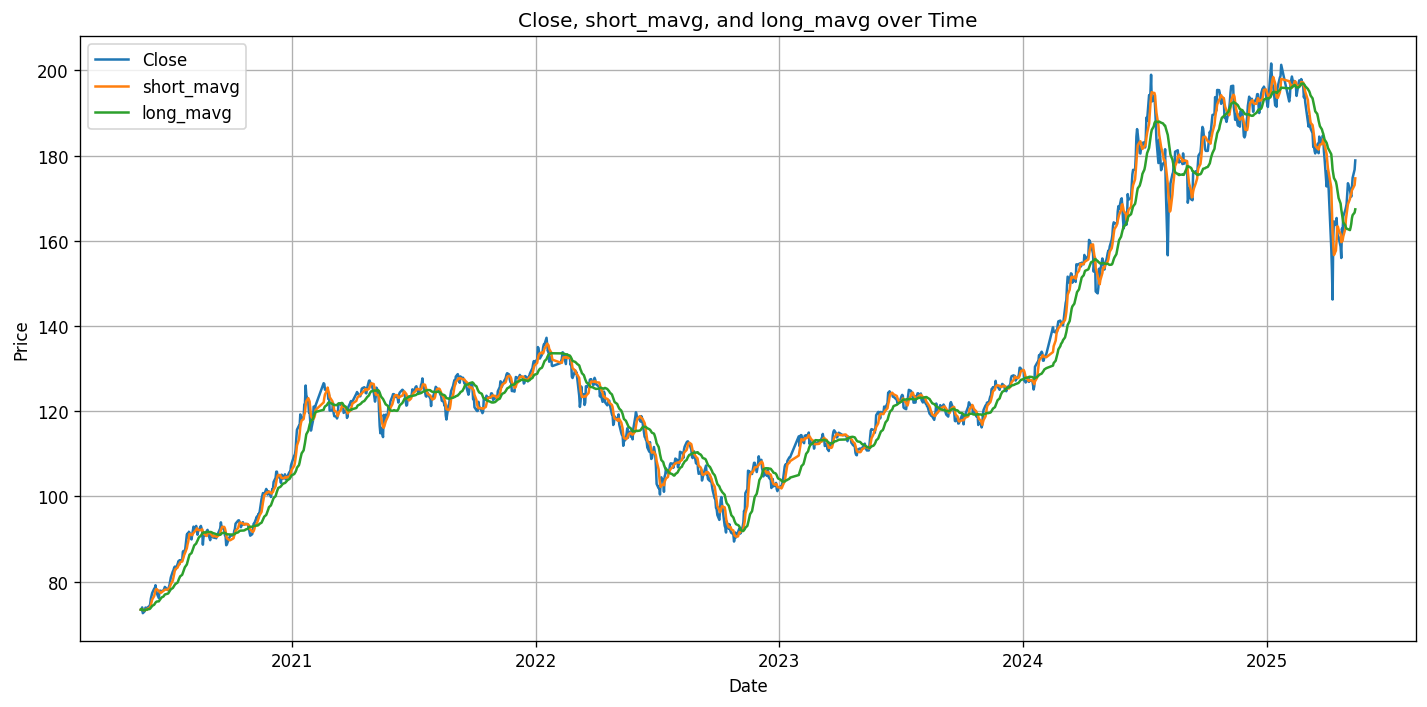

In [14]:
plt.figure(figsize=(12, 6), dpi=120)  # Adjust figure size as needed
plt.plot(dataset['Date'], dataset['Close'], label='Close')
plt.plot(dataset['Date'], dataset['short_mavg'], label='short_mavg')
plt.plot(dataset['Date'], dataset['long_mavg'], label='long_mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close, short_mavg, and long_mavg over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [15]:
# Calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

# Calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

# Calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) # first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) # first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

# Calculation of stochastic osillator.
def STOK(close, low, high, n):
    # Convert columns to numeric, handling errors
    low = pd.to_numeric(low, errors='coerce')
    high = pd.to_numeric(high, errors='coerce')
    close = pd.to_numeric(close, errors='coerce')

    # Fill NaNs with previous valid numeric values
    low = low.ffill()
    high = high.ffill()
    close = close.ffill()

    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    # Convert columns to numeric, handling errors
    low = pd.to_numeric(low, errors='coerce')
    high = pd.to_numeric(high, errors='coerce')
    close = pd.to_numeric(close, errors='coerce')

    # Fill NaNs with previous valid numeric values
    low = low.ffill()
    high = high.ffill()
    close = close.ffill()

    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [16]:
# Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1206,2025-05-07,170.35,172.50,169.95,171.80,13284346,171.08,163.990,1.0,168.517,...,50.608,70.280,78.923,62.593,64.444,43.563,44.852,163.479,179.734,181.049
1207,2025-05-08,172.60,173.20,171.60,172.05,9827807,171.88,165.310,1.0,169.259,...,50.900,84.962,78.646,68.148,64.979,47.430,45.224,164.400,179.397,181.148
1208,2025-05-09,174.75,174.95,172.35,172.70,12972096,172.13,166.008,1.0,170.257,...,51.178,97.884,84.375,73.639,68.126,51.124,47.372,165.760,179.047,181.250
1209,2025-05-12,176.70,177.00,175.50,175.50,13441939,173.08,166.615,1.0,171.429,...,51.428,97.143,93.330,86.612,76.133,54.475,51.010,166.517,178.714,181.342
1210,2025-05-13,178.85,181.10,178.85,180.85,19980679,174.65,167.373,1.0,172.778,...,51.703,84.589,93.205,93.767,84.673,58.170,54.590,167.198,178.402,181.454


In [17]:
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1206,2025-05-07,170.35,172.50,169.95,171.80,13284346,171.08,163.990,1.0,168.517,...,50.608,70.280,78.923,62.593,64.444,43.563,44.852,163.479,179.734,181.049
1207,2025-05-08,172.60,173.20,171.60,172.05,9827807,171.88,165.310,1.0,169.259,...,50.900,84.962,78.646,68.148,64.979,47.430,45.224,164.400,179.397,181.148
1208,2025-05-09,174.75,174.95,172.35,172.70,12972096,172.13,166.008,1.0,170.257,...,51.178,97.884,84.375,73.639,68.126,51.124,47.372,165.760,179.047,181.250
1209,2025-05-12,176.70,177.00,175.50,175.50,13441939,173.08,166.615,1.0,171.429,...,51.428,97.143,93.330,86.612,76.133,54.475,51.010,166.517,178.714,181.342
1210,2025-05-13,178.85,181.10,178.85,180.85,19980679,174.65,167.373,1.0,172.778,...,51.703,84.589,93.205,93.767,84.673,58.170,54.590,167.198,178.402,181.454


In [18]:
# Excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open', 'short_mavg','long_mavg'], axis=1)

In [19]:
dataset = dataset.dropna(axis=0)

In [20]:
dataset.tail()

Price,Date,Close,Volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1206,2025-05-07,170.35,13284346,1.0,168.517,169.686,177.960,4.605,-6.785,14.40,...,50.608,70.280,78.923,62.593,64.444,43.563,44.852,163.479,179.734,181.049
1207,2025-05-08,172.60,9827807,1.0,169.259,169.874,177.907,6.609,-6.526,9.75,...,50.900,84.962,78.646,68.148,64.979,47.430,45.224,164.400,179.397,181.148
1208,2025-05-09,174.75,12972096,1.0,170.257,170.189,177.875,5.430,-5.285,12.85,...,51.178,97.884,84.375,73.639,68.126,51.124,47.372,165.760,179.047,181.250
1209,2025-05-12,176.70,13441939,1.0,171.429,170.609,177.863,5.713,-2.376,10.95,...,51.428,97.143,93.330,86.612,76.133,54.475,51.010,166.517,178.714,181.342
1210,2025-05-13,178.85,19980679,1.0,172.778,171.140,177.873,6.585,-0.195,11.70,...,51.703,84.589,93.205,93.767,84.673,58.170,54.590,167.198,178.402,181.454


<a id='3.4'></a>
## 4.4. Data Visualization

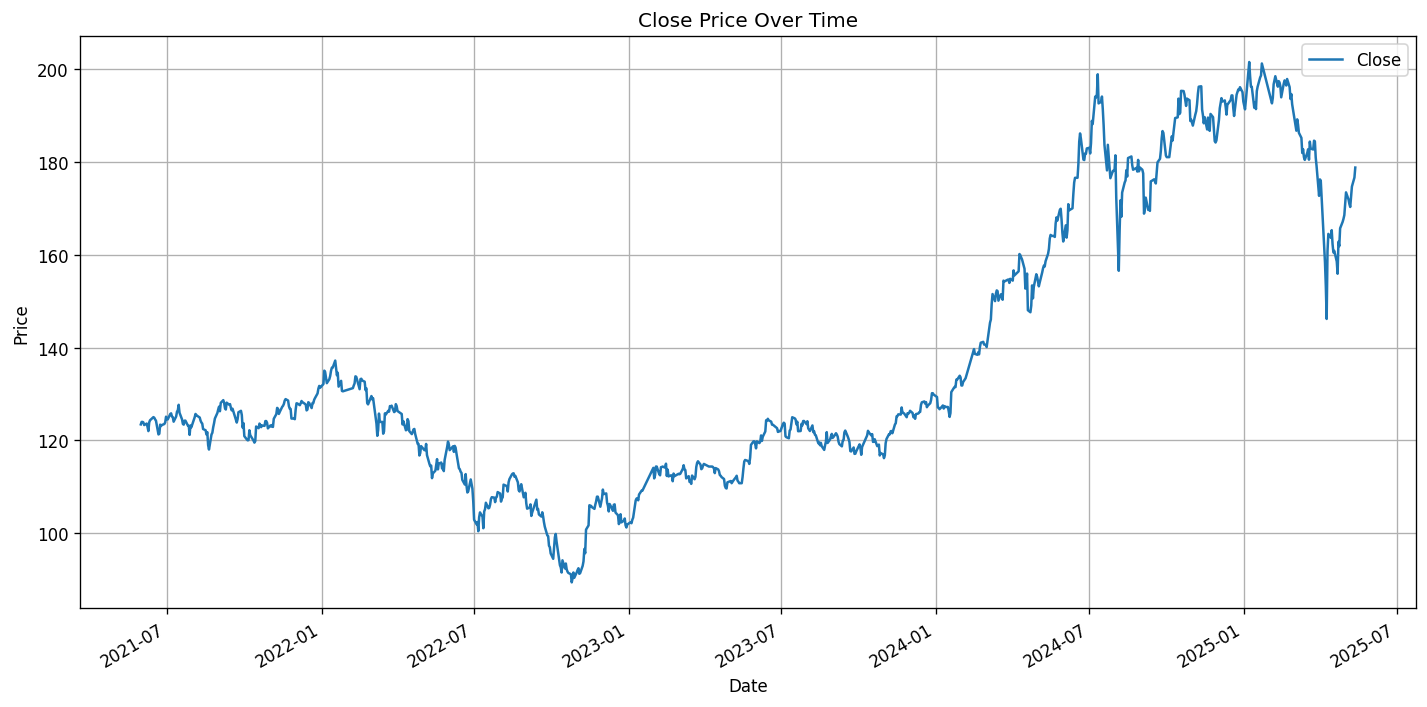

In [21]:
# Assuming 'Date' was originally the index, reset it to a column
dataset = dataset.reset_index()

# Create a new figure with a specified size and resolution (dpi)
plt.figure(figsize=(12, 6), dpi=120)

# Now you can plot on this figure
dataset.plot(x='Date', y='Close', grid=True, ax=plt.gca()) # Use ax=plt.gca() to plot on the current figure

plt.title('Close Price Over Time') # Optional: Add a title
plt.xlabel('Date') # Optional: Add x-axis label
plt.ylabel('Price') # Optional: Add y-axis label

# Display the plot
plt.tight_layout()
plt.show()

In [22]:
dataset = dataset.drop('index', axis=1)

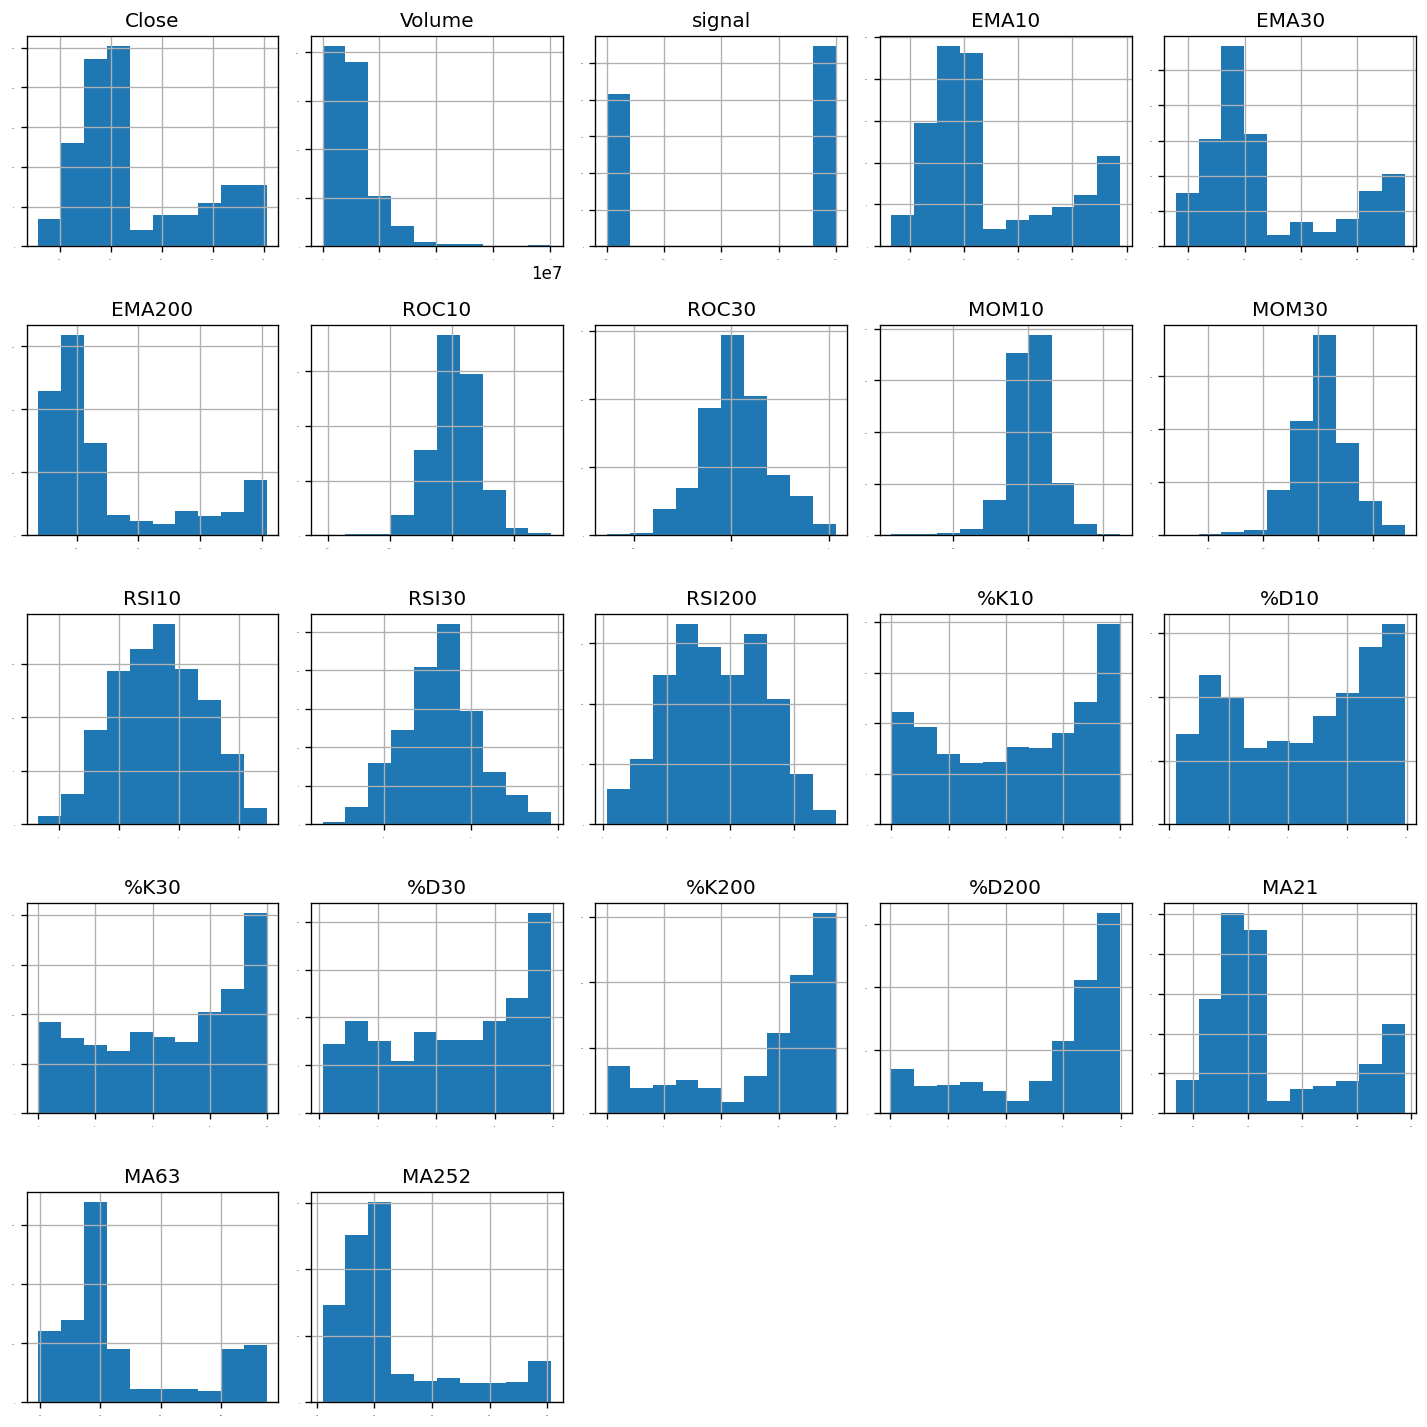

In [23]:
# Select only numeric columns, excluding 'Date'
numeric_data = dataset.select_dtypes(include=np.number)
numeric_data = numeric_data.drop(columns=['Date'], errors='ignore')  # Remove 'Date' if present

# Plot histograms for the remaining numeric columns
fig = plt.figure(figsize=(12, 12), dpi=120)
numeric_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, ax=fig.gca())
plt.tight_layout()
plt.show()

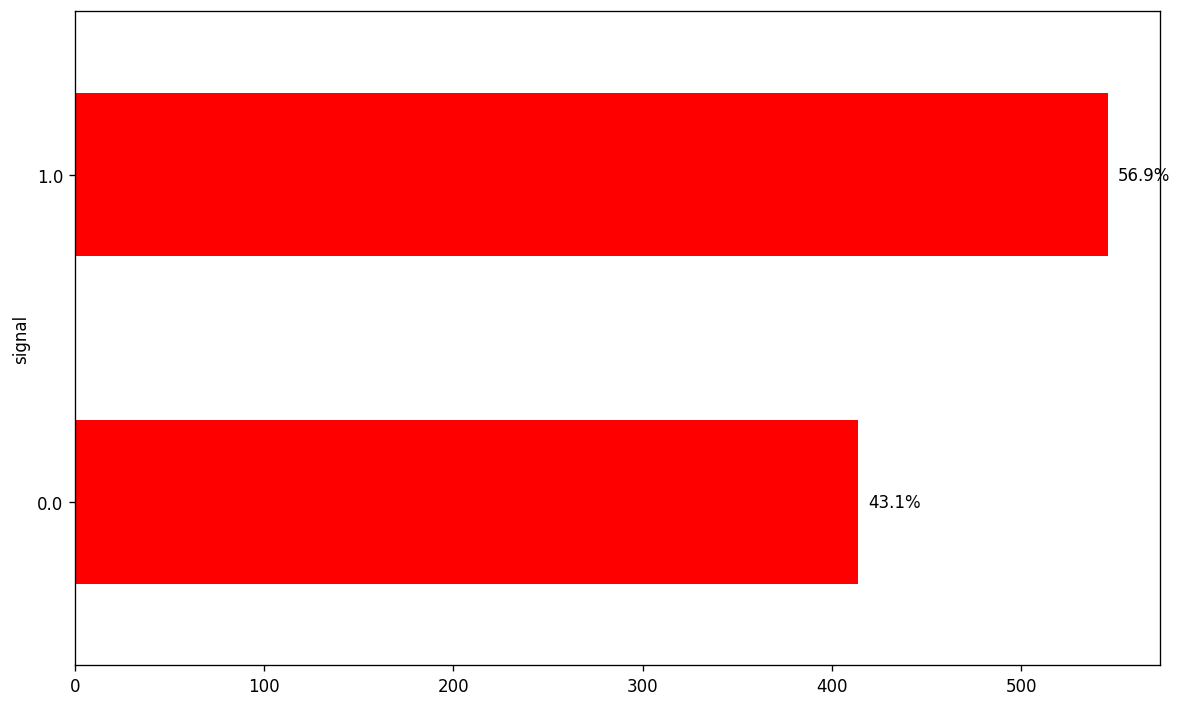

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6), dpi=120)
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')

# Get total count
total = len(dataset)

# Add percentages as text on the bars
for p in plot.patches:
    width = p.get_width()  # Get bar width (count)
    height = p.get_height()
    x, y = p.get_xy()  # Get bar position
    plot.annotate(f'{width/total:.1%}', (x + width + 5, y + height/2),
                  ha='left', va='center', color='black')  # Annotate with percentage

plt.tight_layout()
plt.show()

The predicted variable is upward 56% out of total data-size, meaning that number
of the buy signals were more than the number of sell signals.

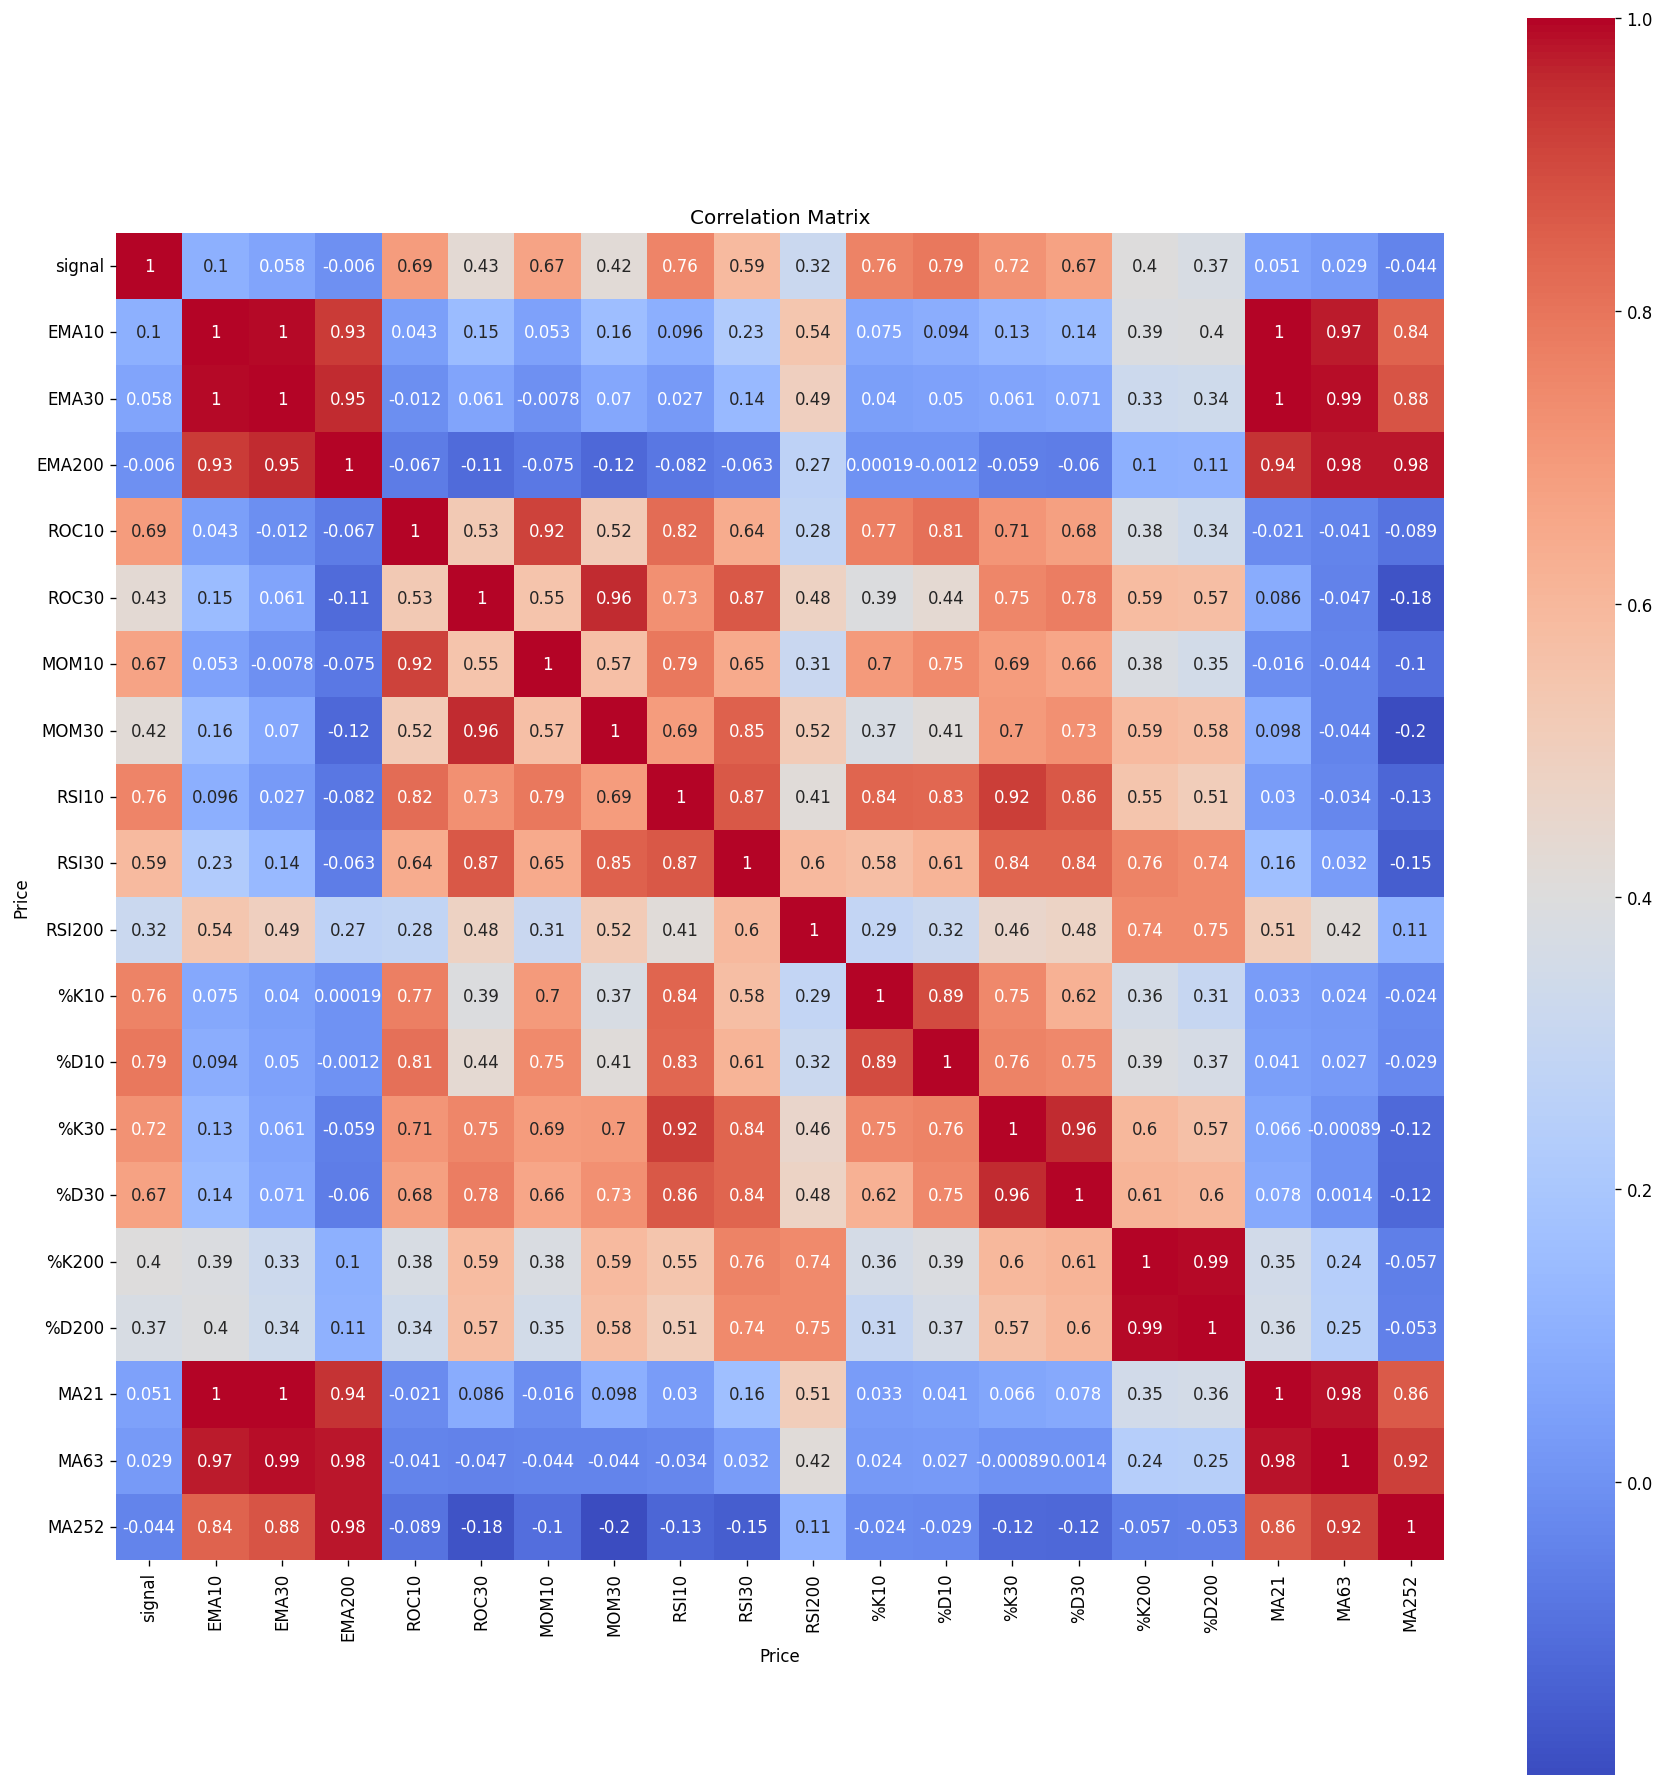

In [25]:
# Select only numeric columns, excluding 'Close', 'Volume'
correlation = dataset.drop(columns=['Close', 'Volume']).select_dtypes(include=np.number).corr()

plt.figure(figsize=(15, 15), dpi=120)
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show() # Add this line to display the plot

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [26]:
# split out validation dataset for the end
Y= dataset["signal"]
# X = dataset.loc[:, dataset.columns != 'signal']

# Select only numerical features for X
numerical_features = dataset.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('signal')  # Remove the target variable from features
numerical_features.remove('Volume')  # Remove 'Volume'
numerical_features.remove('Close')  # Remove 'Close'
X = dataset[numerical_features]

test_size = 0.2
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [27]:
# test options for classification
num_folds = 10
seed = 11218014
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [28]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))

# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [29]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.911432 (0.034850)
RF: 0.914046 (0.029789)


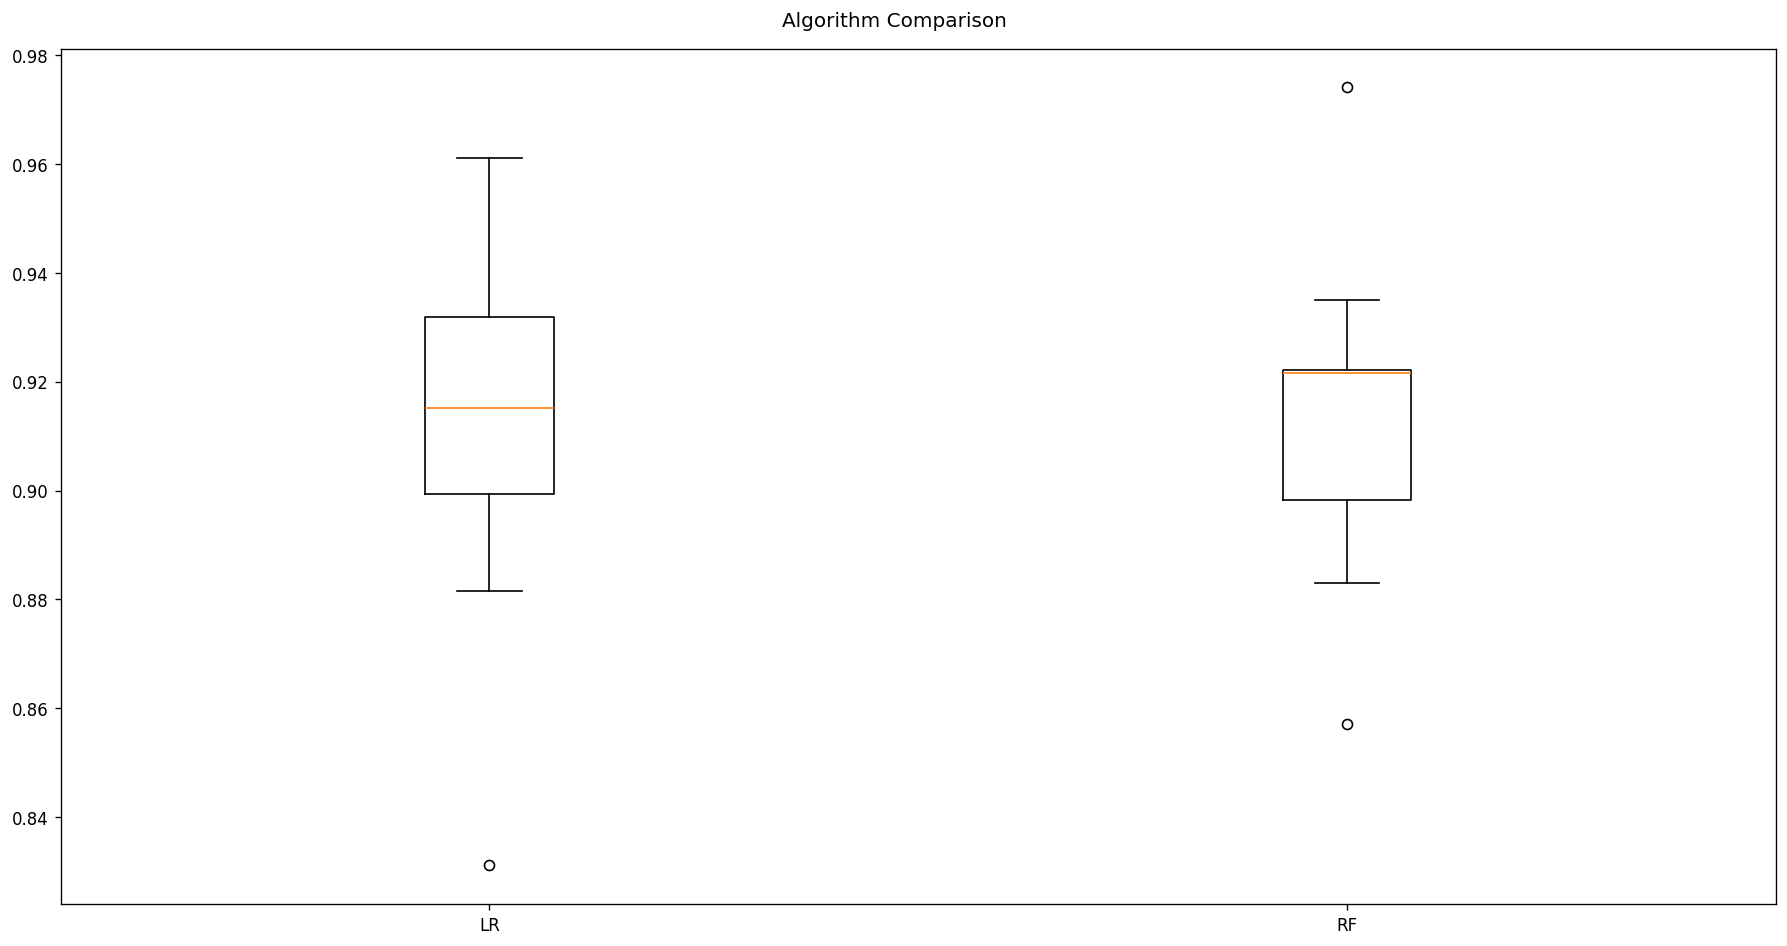

In [30]:
# compare algorithms
fig = plt.figure(figsize=(15, 8), dpi=120)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.tight_layout()
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [31]:
# Grid Search: Logistic Regression

# Scale the training data using only numerical features
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],  # Solvers that support both l1 and l2 penalties
    'max_iter': [100, 500, 1000]
}

# Create a Logistic Regression model
model = LogisticRegression(n_jobs=-1)

# Keep the KFold setup the same
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.911449 using {'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
#82 0.416798 (0.042063) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.583202 (0.042063) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
#70 0.882758 (0.021289) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
#76 0.874897 (0.041616) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
#82 0.416798 (0.042063) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.583202 (0.042063) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
#70 0.882758 (0.021289) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
#76 0.874897 (0.041616) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
#82 0.416798 (0.042063) with: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.583202 (0.042063) with: {

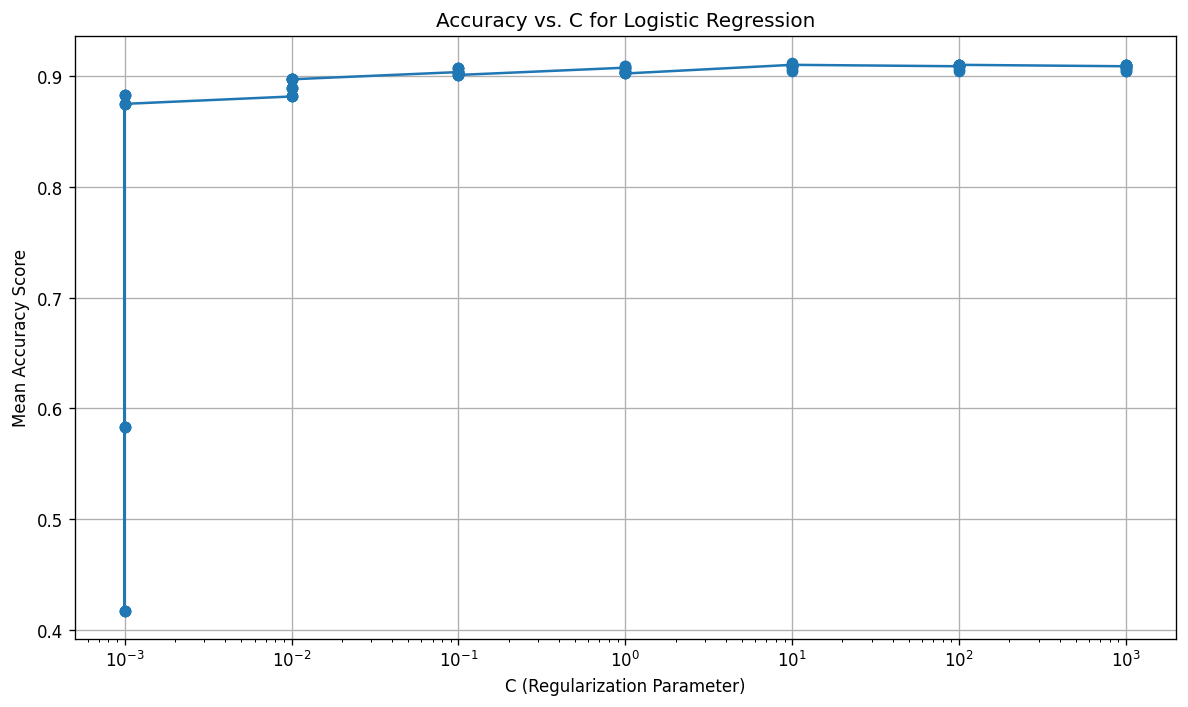

In [32]:
# Check model fit
# Extract relevant data from grid_result
C_values = [params['C'] for params in grid_result.cv_results_['params']]
mean_scores = grid_result.cv_results_['mean_test_score']

# Create the plot
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(C_values, mean_scores, marker='o', linestyle='-')
plt.xscale('log')  # Use logarithmic scale for x-axis to better visualize wide range of C values
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. C for Logistic Regression')
plt.grid(True)
plt.tight_layout()
plt.show()

Logistic Regression is selected for the grid search as it is one of the best models out of all.

In [34]:
# Grid Search: Random Forest
print("Grid Search: Random Forest")

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=seed, n_jobs=-1)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search
grid_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring=scoring, cv=kfold)
grid_result_rf = grid_rf.fit(rescaledX, Y_train)

# Print results
print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))
means_rf = grid_result_rf.cv_results_['mean_test_score']
stds_rf = grid_result_rf.cv_results_['std_test_score']
params_rf = grid_result_rf.cv_results_['params']
ranks_rf = grid_result_rf.cv_results_['rank_test_score']

# Print top 10 results for Random Forest
top_ranks = np.argsort(ranks_rf)[:10]  # Get indices of top 10 results
print("\nTop 10 Random Forest configurations:")
for i in top_ranks:
    print("#%d %f (%f) with: %r" % (ranks_rf[i], means_rf[i], stds_rf[i], params_rf[i]))

Grid Search: Random Forest
Best: 0.927102 using {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Top 10 Random Forest configurations:
#1 0.927102 (0.022607) with: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
#1 0.927102 (0.025417) with: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
#3 0.924504 (0.027687) with: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
#3 0.924504 (0.027687) with: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
#3 0.924504 (0.027687) with: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
#6 0.923172 (0.024276) with: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators':

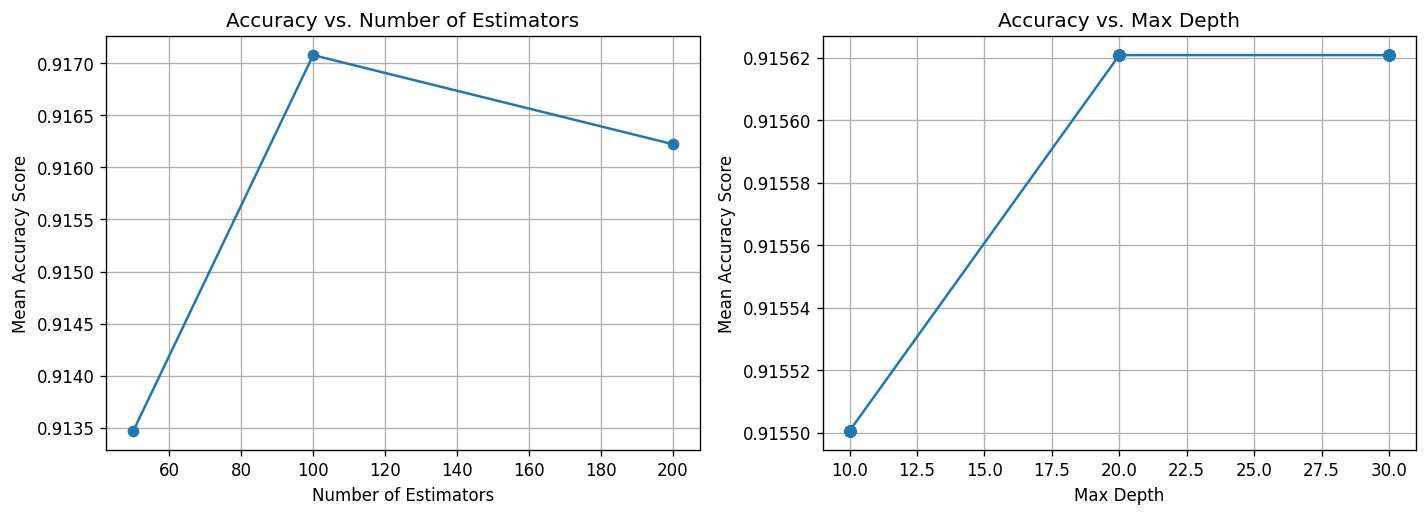

In [38]:
# Visualize Random Forest hyperparameter tuning
plt.figure(figsize=(12, 8), dpi=120)

# Plot n_estimators vs score
n_estimators_values = [100, 100, 100]  # Placeholder, we'll replace with actual values
mean_scores_by_estimators = []

# Group results by n_estimators and calculate mean scores
unique_estimators = sorted(set(p['n_estimators'] for p in params_rf))
for n_est in unique_estimators:
    indices = [i for i, p in enumerate(params_rf) if p['n_estimators'] == n_est]
    mean_score = np.mean([means_rf[i] for i in indices])
    mean_scores_by_estimators.append(mean_score)

plt.subplot(2, 2, 1)
plt.plot(unique_estimators, mean_scores_by_estimators, marker='o', linestyle='-')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. Number of Estimators')
plt.grid(True)

# Plot max_depth vs score
max_depth_values = []
mean_scores_by_depth = []

# Group results by max_depth and calculate mean scores
unique_depths = sorted([p['max_depth'] for p in params_rf if p['max_depth'] is not None])
if unique_depths:  # Only plot if we have non-None depths
    for depth in unique_depths:
        indices = [i for i, p in enumerate(params_rf) if p['max_depth'] == depth]
        mean_score = np.mean([means_rf[i] for i in indices])
        mean_scores_by_depth.append(mean_score)

    plt.subplot(2, 2, 2)
    plt.plot(unique_depths, mean_scores_by_depth, marker='o', linestyle='-')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Accuracy Score')
    plt.title('Accuracy vs. Max Depth')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Comparing Logistic Regression and Random Forest

We'll now compare the performance of the best Logistic Regression model with the best Random Forest model.

In [39]:
# Prepare the best Logistic Regression model
print("Preparing the best Logistic Regression model...")
best_lr = LogisticRegression(**grid_result.best_params_, random_state=seed, n_jobs=-1)
best_lr.fit(X_train, Y_train)

# Prepare the best Random Forest model
print("Preparing the best Random Forest model...")
best_rf = RandomForestClassifier(**grid_result_rf.best_params_, random_state=seed, n_jobs=-1)
best_rf.fit(X_train, Y_train)

# Make predictions with both models
lr_predictions = best_lr.predict(X_test)
rf_predictions = best_rf.predict(X_test)

# Calculate accuracy scores
lr_accuracy = accuracy_score(Y_test, lr_predictions)
rf_accuracy = accuracy_score(Y_test, rf_predictions)

print("\nLogistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

Preparing the best Logistic Regression model...
Preparing the best Random Forest model...

Logistic Regression Accuracy: 0.90625
Random Forest Accuracy: 0.8958333333333334


In [41]:
# Compare confusion matrices
print("Logistic Regression Confusion Matrix:")
lr_cm = confusion_matrix(Y_test, lr_predictions)
print(lr_cm)

print("\nRandom Forest Confusion Matrix:")
rf_cm = confusion_matrix(Y_test, rf_predictions)
print(rf_cm)

# Compare classification reports
print("\nLogistic Regression Classification Report:")
print(classification_report(Y_test, lr_predictions))

print("\nRandom Forest Classification Report:")
print(classification_report(Y_test, rf_predictions))

Logistic Regression Confusion Matrix:
[[83 11]
 [ 7 91]]

Random Forest Confusion Matrix:
[[81 13]
 [ 7 91]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90        94
         1.0       0.89      0.93      0.91        98

    accuracy                           0.91       192
   macro avg       0.91      0.91      0.91       192
weighted avg       0.91      0.91      0.91       192


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89        94
         1.0       0.88      0.93      0.90        98

    accuracy                           0.90       192
   macro avg       0.90      0.90      0.90       192
weighted avg       0.90      0.90      0.90       192



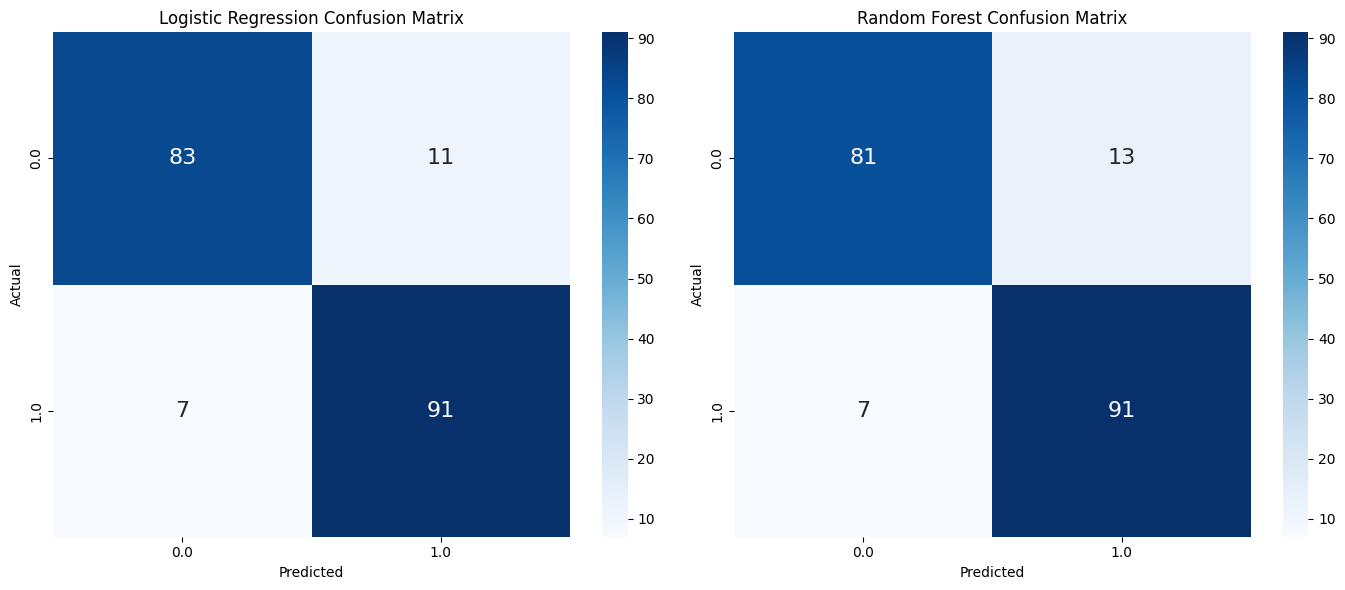

In [42]:
# Plot confusion matrices
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df_cm_lr = pd.DataFrame(lr_cm, columns=np.unique(Y_test), index=np.unique(Y_test))
df_cm_lr.index.name = 'Actual'
df_cm_lr.columns.name = 'Predicted'
sns.heatmap(df_cm_lr, cmap="Blues", annot=True, annot_kws={"size": 16})
plt.title("Logistic Regression Confusion Matrix")

plt.subplot(1, 2, 2)
df_cm_rf = pd.DataFrame(rf_cm, columns=np.unique(Y_test), index=np.unique(Y_test))
df_cm_rf.index.name = 'Actual'
df_cm_rf.columns.name = 'Predicted'
sns.heatmap(df_cm_rf, cmap="Blues", annot=True, annot_kws={"size": 16})
plt.title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()

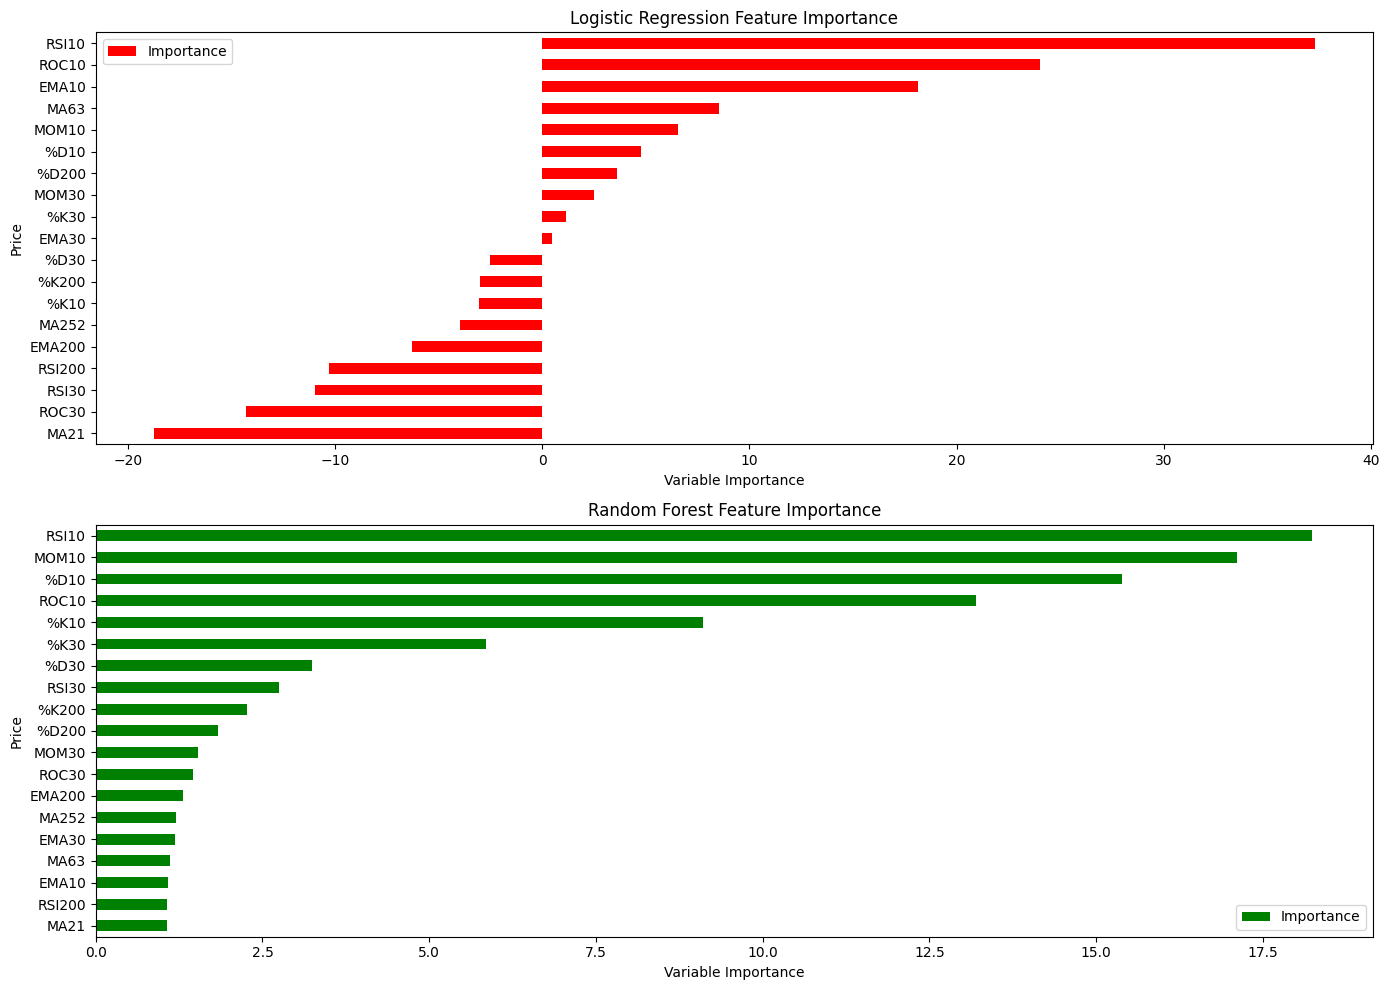

In [44]:
# Feature importance comparison
plt.figure(figsize=(14, 10))

# Logistic Regression feature importance
plt.subplot(2, 1, 1)
lr_importance = pd.DataFrame({'Importance': best_lr.coef_[0]}, index=X.columns)
lr_importance['Importance'] = lr_importance['Importance'] * 100  # scale by 100
lr_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', ax=plt.gca()) # Add ax=plt.gca()
plt.xlabel('Variable Importance')
plt.title('Logistic Regression Feature Importance')

# Random Forest feature importance
plt.subplot(2, 1, 2)
rf_importance = pd.DataFrame({'Importance': best_rf.feature_importances_}, index=X.columns)
rf_importance['Importance'] = rf_importance['Importance'] * 100  # scale by 100
rf_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='g', ax=plt.gca()) # Add ax=plt.gca()
plt.xlabel('Variable Importance')
plt.title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()

## Random Forest Model Explanation and Generalizability

### Model Explanation:
Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Key characteristics:
1. **Ensemble Method**: Combines predictions from multiple decision trees to reduce overfitting and increase accuracy
2. **Bootstrap Aggregating (Bagging)**: Each tree is trained on a random subset of the training data (with replacement)
3. **Feature Randomness**: At each split, only a random subset of features is considered
4. **Voting Mechanism**: Final prediction is determined by majority voting from all trees

### Comparing with Logistic Regression:
1. **Complexity**: Random Forest is more complex than Logistic Regression, allowing it to capture non-linear patterns in the data
2. **Interpretability**: Logistic Regression offers better interpretability with coefficient values directly indicating feature importance
3. **Feature Importance**: Random Forest provides feature importance based on how much each feature reduces impurity across all trees

### Generalizability Assessment:
1. **Robustness to Overfitting**: Random Forest is less prone to overfitting compared to single decision trees due to its ensemble nature
2. **Handling Non-Linear Relationships**: Better at capturing complex non-linear relationships in the data
3. **Noise Tolerance**: More robust to noise and outliers in the data
4. **Missing Values**: Can handle missing values effectively
5. **Performance on Unseen Data**: The out-of-bag (OOB) error estimate provides an unbiased estimate of the model's performance on unseen data

### Market Strategy Implications:
In financial market prediction, Random Forest offers advantages through its ability to:
1. Capture complex market patterns that may not be linear
2. Be less sensitive to market noise and outliers
3. Handle the high dimensionality of financial data with many technical indicators
4. Provide reliable feature importance rankings that can inform strategy development

Let's now compare the trading performance of both models:


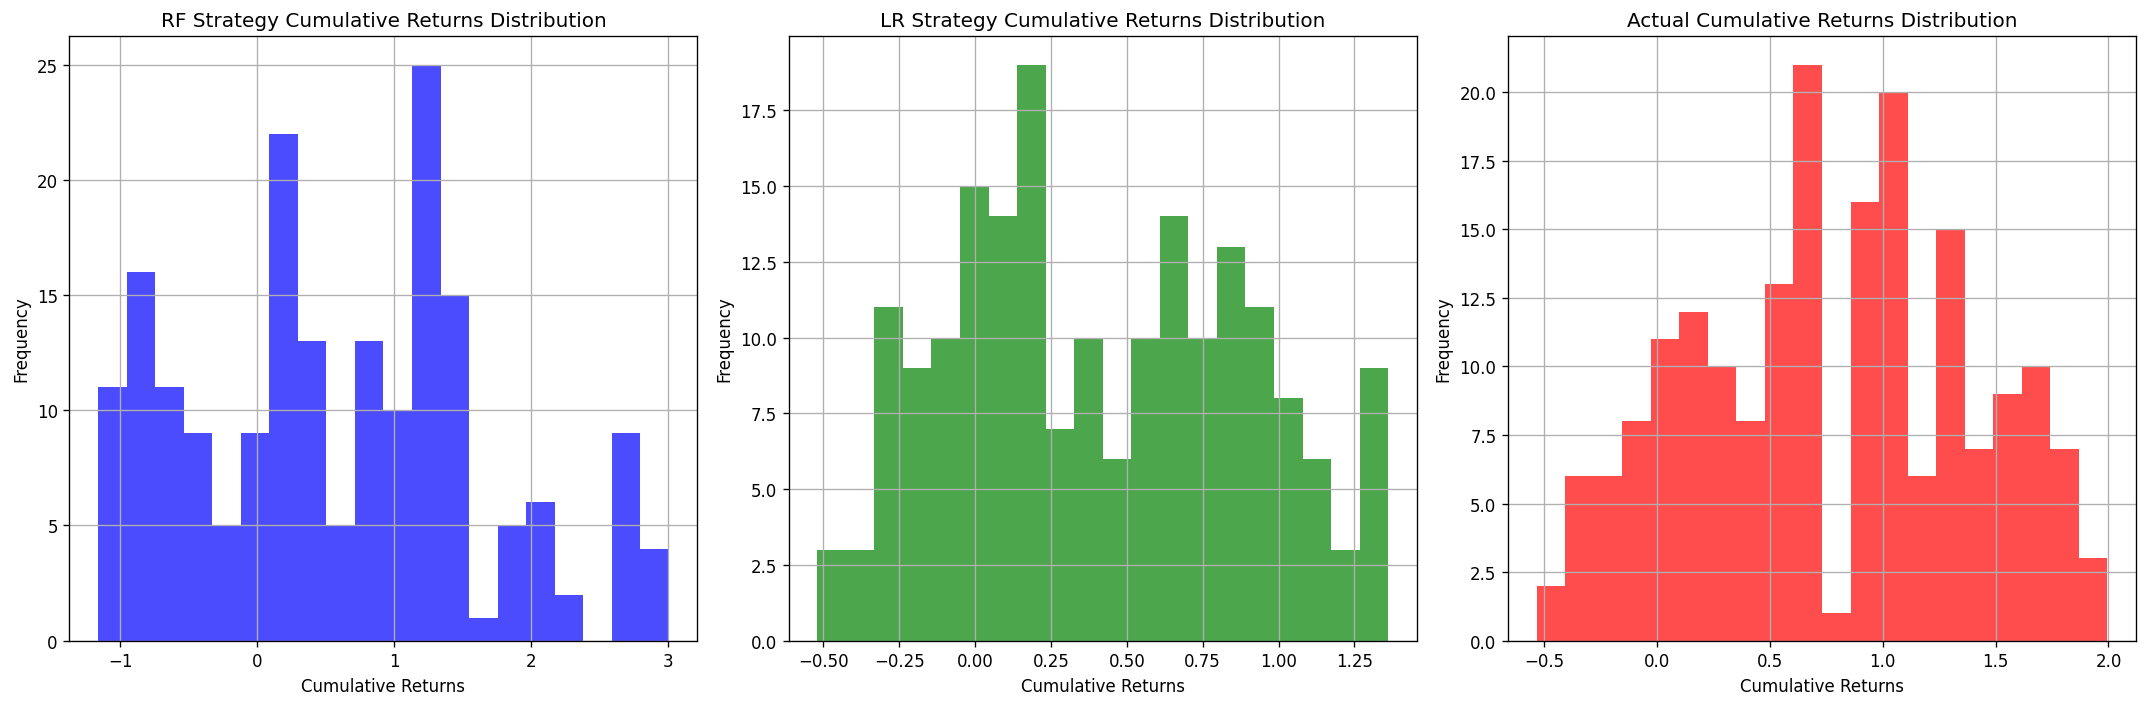

In [60]:
# Create a figure with three subplots (histograms)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=120)

# Subplot 1: Histogram of RF strategy cumulative returns
rf_backtestdata['Strategy Returns'].cumsum().hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('RF Strategy Cumulative Returns Distribution')
axes[0].set_xlabel('Cumulative Returns')
axes[0].set_ylabel('Frequency')

# Subplot 2: Histogram of LR strategy cumulative returns
lr_backtestdata['Strategy Returns'].cumsum().hist(ax=axes[1], bins=20, color='green', alpha=0.7)
axes[1].set_title('LR Strategy Cumulative Returns Distribution')
axes[1].set_xlabel('Cumulative Returns')
axes[1].set_ylabel('Frequency')

# Subplot 3: Histogram of actual cumulative returns
rf_backtestdata['Actual Returns'].cumsum().hist(ax=axes[2], bins=20, color='red', alpha=0.7)
axes[2].set_title('Actual Cumulative Returns Distribution')
axes[2].set_xlabel('Cumulative Returns')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

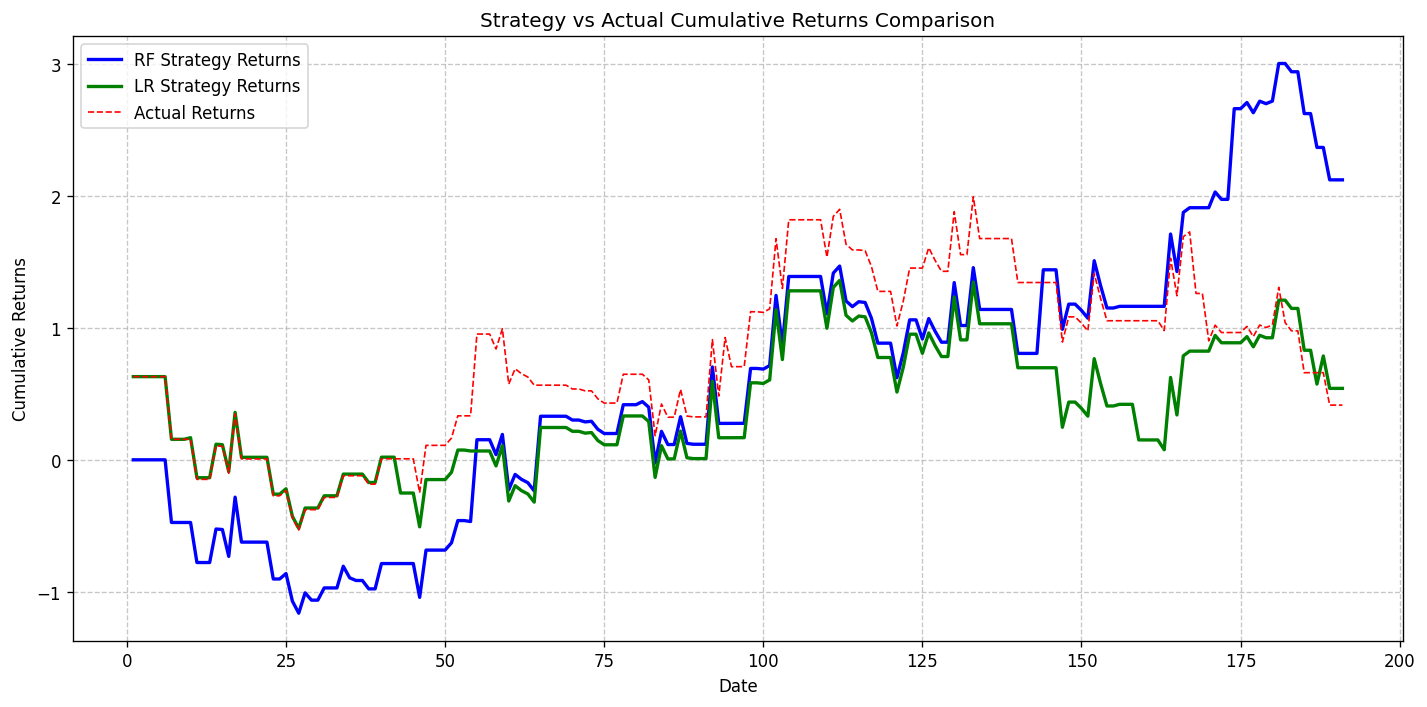

In [59]:
# Create a line chart showing the cumulative returns of both strategies and actual returns
plt.figure(figsize=(12, 6), dpi=120)

# Plot RF strategy returns
plt.plot(rf_backtestdata.index, rf_backtestdata['Strategy Returns'].cumsum(),
         linewidth=2, label='RF Strategy Returns', color='blue')

# Plot LR strategy returns
plt.plot(lr_backtestdata.index, lr_backtestdata['Strategy Returns'].cumsum(),
         linewidth=2, label='LR Strategy Returns', color='green')

# Plot actual returns
plt.plot(rf_backtestdata.index, rf_backtestdata['Actual Returns'].cumsum(),
         linewidth=1, linestyle='--', label='Actual Returns', color='red')

plt.title('Strategy vs Actual Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [64]:
# Calculate cumulative returns for RF
cumulative_strategy_returns_rf = rf_backtestdata['Strategy Returns'].cumsum()
cumulative_actual_returns_rf = rf_backtestdata['Actual Returns'].cumsum()

# Calculate percentage of cumulative strategy returns over actual returns for RF
percentage_returns_rf = (cumulative_strategy_returns_rf / cumulative_actual_returns_rf) * 100

# Remove NaN values before accessing the last element for RF
percentage_returns_rf = percentage_returns_rf.dropna()

# Print or display the result for RF
print(f"Percentage of Cumulative Strategy Returns (RF) over Actual Returns: {percentage_returns_rf.iloc[-1]:.2f}%")

# Calculate cumulative returns for LR
cumulative_strategy_returns_lr = lr_backtestdata['Strategy Returns'].cumsum()
cumulative_actual_returns_lr = lr_backtestdata['Actual Returns'].cumsum()

# Calculate percentage of cumulative strategy returns over actual returns for LR
percentage_returns_lr = (cumulative_strategy_returns_lr / cumulative_actual_returns_lr) * 100

# Remove NaN values before accessing the last element for LR
percentage_returns_lr = percentage_returns_lr.dropna()

# Print or display the result for LR
print(f"Percentage of Cumulative Strategy Returns (LR) over Actual Returns: {percentage_returns_lr.iloc[-1]:.2f}%")

Percentage of Cumulative Strategy Returns (RF) over Actual Returns: 511.87%
Percentage of Cumulative Strategy Returns (LR) over Actual Returns: 130.59%
